<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/RMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Matrix Theory based dimensionality reduction and classification
By [Fayyaz Minhas](https://sites.google.com/view/fayyaz)

How to select principal components to avoid selecting noise components? For this purpose, we can usesome results from random matrix theory.

Specifically, we will be using the [Marchenko–Pastur law](https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution) which describes the asymptotic behavior of singular values of random matrices and can be stated as follows:

If entries in a matrix $𝑋∈𝑅^{(𝑁×𝑝)}$ consisting of 𝑁 samples of 𝑝 dimensions are drawn from a Normal distribution, the probability of the covariance matrix $𝐶∈𝑅^{(𝑝×𝑝)}$  having an eigen value 𝜆 is given by the following probability distribution (with $\gamma=𝑝/𝑁$):

$$\rho(\lambda)=\frac{\sqrt{[(1+\sqrt{\gamma})^2-\lambda]_+[\lambda-(1-\sqrt{\gamma})^2]_+}}{2\pi \lambda}$$

Thus, the probability that the Eigen value of a random matrix is larger than $𝜃=(1+√𝛾)^2$ is almost zero and that can be chosen as a threshold to select the largest eigen values. This will in essence ensure that the eigen vectors we pick correspond to statistically significant signals and not noise.

Below, we use a simulation to show this in action by generating sample random data and plotting the distribution of the eigen values of its covariance matrix.

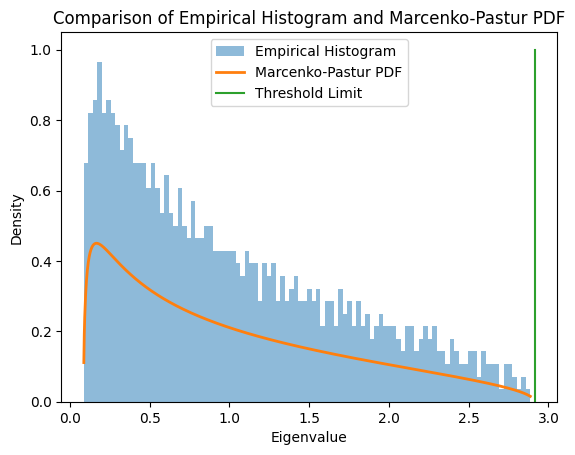

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def marcenko_pastur_pdf(lam, sigma, N, p):
    """Compute the Marcenko-Pastur PDF."""
    lambda_plus = sigma**2 * (1 + np.sqrt(p/N))**2
    lambda_minus = sigma**2 * (1 - np.sqrt(p/N))**2
    return lambda x: (1 / (2 * np.pi * sigma**2 * x)) * np.sqrt((lambda_plus - x) * (x - lambda_minus)) * (x > lambda_minus) * (x < lambda_plus)

# Parameters
N, p = 2000, 1000  # Dimensions of the matrix
sigma = 1  # Standard deviation of the normal distribution
B = 100  # Number of bins for the histogram

# Generate a sample matrix X
X = np.random.normal(0, sigma, (N, p))

# Compute the sample covariance matrix C and its eigenvalues
C = np.cov(X, rowvar=False)
eigenvalues = np.linalg.eigvalsh(C)

# Plot the empirical histogram of eigenvalues
plt.hist(eigenvalues, bins=B, density=True, alpha=0.5, label='Empirical Histogram')

# Generate values for the Marcenko-Pastur PDF
x = np.linspace(eigenvalues.min(), eigenvalues.max(), 1000)
mp_pdf = marcenko_pastur_pdf(lam=p/N, sigma=sigma, N=N, p=p)
y = mp_pdf(x)
t = ((1+np.sqrt(p/N))**2)
# Plot the Marcenko-Pastur PDF
plt.plot(x, y, label='Marcenko-Pastur PDF', linewidth=2)
plt.plot([t,t],[0,1],label='Threshold Limit')
# Finalizing the plot
plt.title('Comparison of Empirical Histogram and Marcenko-Pastur PDF')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()
plt.show()



## Classification

We can use this idea to develop machine learning models such as classifiers. For example, if we have a classification problem, then, for each class we can select the "non-noise" dimensions of its data points and calculate the reconstruction error of a given test point with respect to data points in each class and assign the class label based on which class gives the lowest error.

### Representation

Assume we have (centered or normalized) data for a single class with label $k$ in a dataset of consisting of $K$ classes. We first calculate the $d_k$ non-noise eigen vectors $W_k = [w_k^1|w_k^2|...|w_k^{d_k}]$ of the covariance matrix of the data such that their eigen values are above the threshold $\theta_k$ calculate using the method above. For a given test example, we then compute the reconstruction error of that example:

$$r_k(x)=||\hat{x_k}-x||$$
with the reconstrunction given by: $$\hat{x_k}=W_kW_k^Tx$$
The prediction score for this example to belong to class $k$ is given by:

$$f_k(x)=max_{j=1...K, j\ne k} r_j(x)-r_k(x)$$

It is based on the idea that the reconstruction error of an example that belongs to class $k$ will be the lowest when $W_k$ is used for its reconstruction.

## Evaluation and Optimization

No explicit evaluation and optimization.

This is inspired from this work:

Lee, Alpha A., Michael P. Brenner, and Lucy J. Colwell. “Predicting Protein–Ligand Affinity with a Random Matrix Framework.” Proceedings of the National Academy of Sciences 113, no. 48 (November 29, 2016): 13564–69. https://doi.org/10.1073/pnas.1611138113.

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
class RMTC:
    def __init__(self,t = None):
        self.t = t
    def fit(self,X):
        self.scaler = StandardScaler().fit(X)
        Xn = self.scaler.transform(X)
        self.keep_indices = np.std(Xn,axis=0)>0 # remove columns with no variance
        Xn = Xn[:,self.keep_indices]
        N,p = Xn.shape        # N is the number of example, p is the number of features
        self.N = N
        self.p = p
        C = np.cov(Xn.T)#Xn.T@Xn/N #pxp covariance matrix (the paper wrongly says this is NxN)
        w,v=np.linalg.eig(C) #Eigen values and eigen vectors
        if self.t is None:
          t = ((1+np.sqrt(p/N))**2) #threshold
        w = np.abs(w)
        #self.C = C
        self.t = t
        self.wall = w
        self.w=w[w>=t]
        self.v=v[:,w>=t]
        return self

    def decision_function(self,X):
        Xn = self.scaler.transform(X)
        Xn = Xn[:,self.keep_indices]
        X = X[:,self.keep_indices]
        xv = Xn@self.v #nxd'
        d = Xn-xv@self.v.T #reconsturct using only non-noise components
        z = np.linalg.norm(d,axis=1) #return the reconstruction error
        return z
    def __repr__(self):
      return f"RMT with {len(self.wall)} eigen vectors with {len(self.w)} non-noise vectors at threshold {self.t:.2f}"

class RMTD:
    def __init__(self):
        self.rmt = dict()
    def fit(self,X,y):
        self.Yc = np.sort(list(set(y))) #unique class labels
        for yc in self.Yc:
          rmtc = RMTC().fit(X[y==yc,:])
          self.rmt[yc]=rmtc
        return self
    def decision_function(self,X):
        R = np.zeros((X.shape[0],len(self.Yc)))
        # calculate the reconstruction error
        for idx,(k,rmt) in enumerate(self.rmt.items()):
          R[:,idx] = rmt.decision_function(X)
        Zout = np.zeros_like(R)
        for k in range(R.shape[1]):
          Zout[:,k]=np.min(np.hstack((R[:,:k],R[:,k+1:])),axis=1)-R[:,k]  #min reconstruction error of all other classes - reconstruction error of this class
        return Zout
    def __repr__(self):
        return f"RMT Discriminator: {self.rmt}"



AUCROC 0.9025


<ipython-input-3-00dc08c5ee1a>:76: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


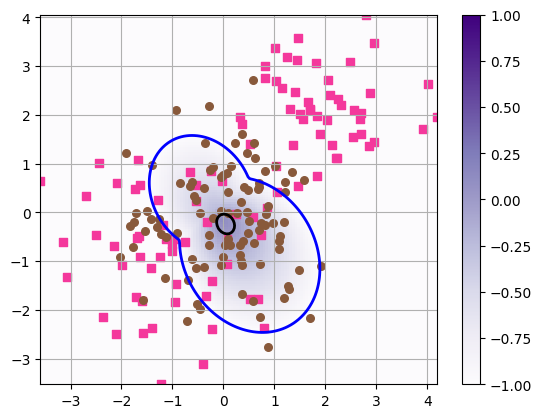

RMT Discriminator: {-1: RMT with 2 eigen vectors with 1 non-noise vectors at threshold 1.34, 1: RMT with 2 eigen vectors with 0 non-noise vectors at threshold 1.34}


In [3]:
# let's generate some example data
def getExamples(n=100,d=2):
    """
    Generates n d-dimensional normally distributed examples of each class
    The mean of the positive class is [1] and for the negative class it is [-1]
    """
    Xp = randn(n,d)#+1   #generate n examples of the positie class
    Xp=Xp+0
    Xn1 = randn(int(n/2),d)#-1   #generate n examples of the negative class
    Xn1=Xn1-1
    Xn2 = randn(int(n/2),d)#-1   #generate n examples of the negative class
    Xn2=Xn2+2
    Xn = np.vstack((Xn1,Xn2))  #Stack the examples together to a single matrix
    X = np.vstack((Xp,Xn))  #Stack the examples together to a single matrix
    Y = np.array([+1]*n+[-1]*n) #Associate Labels
    return (X,Y)

#plotting code (can be ignored)
from numpy.random import randn #importing randn
import numpy as np #importing numpy
import matplotlib.pyplot as plt #importing plotting module
import itertools
import warnings

def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None:
            conts = list(classes)
        vmin,vmax = classes[0]-eps,classes[-1]+eps
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None:
            conts = sorted([-1+eps,0,1-eps])

    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)

        z = np.reshape(z,(npts,npts)).T


        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis(extent)

    if Y is not None:
        for i,y in enumerate(classes):
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 30)

    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('')
    plt.ylabel('')
    if not hold:
        plt.grid()
        plt.show()
    return extent


from sklearn.model_selection import train_test_split
X,y = getExamples(n=100)
Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.2, shuffle = True, stratify = None)#, random_state=42)

clf = RMTD().fit(Xtr,ytr)
Z = clf.decision_function(Xv)
clfplt = lambda x: clf.decision_function(x)[:,1]
from sklearn.metrics import roc_auc_score
print("AUCROC",roc_auc_score(yv,Z[:,1]))
plt.figure() ;plotit(X = X, Y = y, clf = clfplt, conts =[-1,0,1], colors = 'random')
print(clf)

#### Note

Notice how the RMT for the negative and positive classes retain 1 and 0 components, respectively. This is because the positive class is essentially normally distributed!

In [4]:
clf.rmt[-1].wall,clf.rmt[-1].t

(array([0.319436  , 1.70588046]), 1.341227766016838)

In [5]:
#Let's try another classification problem
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.datasets import make_classification

X, y = load_iris(return_X_y=True)
#X, y = make_classification(n_samples=500, n_features=1000, n_informative=50, n_redundant=100, n_classes=2, random_state=42)

Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.2, shuffle = True, stratify = None)#, random_state=42)
clf = RMTD().fit(Xtr,ytr)
Z = clf.decision_function(Xv)
from sklearn.metrics import roc_auc_score
for i,k in enumerate(clf.Yc):
  print(f"AUCROC of class {k}: {roc_auc_score(yv==k,Z[:,i])}")
print(clf)

AUCROC of class 0: 1.0
AUCROC of class 1: 1.0
AUCROC of class 2: 1.0
RMT Discriminator: {0: RMT with 4 eigen vectors with 1 non-noise vectors at threshold 1.75, 1: RMT with 4 eigen vectors with 1 non-noise vectors at threshold 1.72, 2: RMT with 4 eigen vectors with 1 non-noise vectors at threshold 1.72}
